## Libs

In [25]:

import os
import time
import math
import datetime
from math import log, floor
from sklearn.neighbors import KDTree

import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.utils import shuffle
from tqdm.notebook import tqdm as tqdm

import seaborn as sns
from matplotlib import colors
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots

from statsmodels.robust import mad

import scipy
import statsmodels
from scipy import signal
from prophet import Prophet
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.api import ExponentialSmoothing 

import warnings
warnings.filterwarnings("ignore")

## Load data

In [26]:
!mkdir Outputs 
!mkdir static_data 

A subdirectory or file Outputs already exists.
A subdirectory or file static_data already exists.


Sugestão - Rodar em ambiente virtual ".env" e aplicar arquivo `requiments.txt`

`Passo a Passo`:

- python -m venv .env
- .env\Scripts\activate   --> (terminal Bash = source .env/scripts/activate)
- pip install -r requirements.txt

In [27]:
INPUT_DIR = 'static_data'  # Altere para o seu diretório local
OUTPUTS_DIR = 'Outputs'  # Altere para o seu diretório local
calendar = pd.read_csv(f'{INPUT_DIR}/calendar.csv')
selling_prices = pd.read_csv(f'{INPUT_DIR}/sell_prices.csv')
sales_train_eval = pd.read_csv(f'{INPUT_DIR}/sales_train_evaluation.csv')

In [28]:
ids = sorted(list(set(sales_train_eval['id'])))
d_cols = [c for c in sales_train_eval.columns if 'd_' in c]

## Pre-prossing

#### Data Types

In [29]:
calendar.dtypes

date            object
wm_yr_wk         int64
weekday         object
wday             int64
month            int64
year             int64
d               object
event_name_1    object
event_type_1    object
event_name_2    object
event_type_2    object
snap_CA          int64
snap_TX          int64
snap_WI          int64
dtype: object

In [30]:
selling_prices.dtypes

store_id       object
item_id        object
wm_yr_wk        int64
sell_price    float64
dtype: object

- Para a base `sales_train_evaluation` temos um alto volume de linhas e colunas, fazer a abordagem tradicional de avaliação de tipagem seria bem complexa. 
- Para essa base seguirei uma abordagem de interpretação lógica. A `base original` contém `1947 colunas`, sendo que 1941 são do tipo 'int' e apenas 6 'object'. Ao avaliar as top 10 colunas, chegamos a conclusão que as 6 primeiras são do tipo 'object', com isso, chegamos a conclusão que todas as outras são 'int'. Importante essa analise, no dia a dia, uma base que é de gestão do time de negócio pode vir colunas com a mesma informação (exemplo: vendas/mês), porém com tipagem diferentes. Caso não tratado pode gerar problemas de conversão ou até `overfitting` no modelo. 

In [31]:
print('\nBase em seu total de colunas:\n',sales_train_eval.dtypes.value_counts())
print('-'*60)

sales_top10_cols = sales_train_eval.dtypes[:10]
dtype_counts = sales_top10_cols.value_counts()
print('\nBase apenas com TOP 10 colunas:\n',dtype_counts)


Base em seu total de colunas:
 int64     1941
object       6
Name: count, dtype: int64
------------------------------------------------------------

Base apenas com TOP 10 colunas:
 object    6
int64     4
Name: count, dtype: int64


#### Missing Values

- A única base com valores ausentes foi a `calendario`, segui a seguinte abordagem:
    - Preenchi os valores nulos das colunas de eventos com 'No_Event' para representar explicitamente a ausência de eventos nos dias correspondentes. Valores nulos poderiam causar problemas durante o processamento e modelagem dos dados. Além disso, facilita a codificação das variáveis categóricas e permite que o modelo diferencie entre dias com e sem eventos, potencialmente melhorando a precisão das previsões.

In [32]:
sales_train_eval_na = sales_train_eval.isna().sum()>0
sales_train_eval_na.value_counts()

False    1947
Name: count, dtype: int64

In [33]:
sell_prices_na = selling_prices.isna().sum()>1
sell_prices_na.value_counts()

False    4
Name: count, dtype: int64

In [34]:
calendar_na = calendar.isna().sum()>0
calendar_na.value_counts()

False    10
True      4
Name: count, dtype: int64

Na base `calendar` existem colunas("Event") que representam datas sazonais (Feriados e datas comemorativas), dado isso faz sentido existir dados ausentos nos demais dias "não Events". Afim de entender como `Next step` futuro não irei deletar essas colunas. 

## EDA - Basic

In [35]:
# Dataframe, formato wide p/long
sales_train_eval_eda = pd.melt(sales_train_eval,
                     id_vars=['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'],
                     var_name='d',
                     value_name='sales')


sales_train_eval_eda = sales_train_eval_eda.merge(calendar[['d', 'date','wm_yr_wk']], on='d', how='left')

# Convertendo a coluna 'date' para datetime
sales_train_eval_eda['date'] = pd.to_datetime(sales_train_eval_eda['date'])

# criação coluna para o mês
sales_train_eval_eda['month'] = sales_train_eval_eda['date'].dt.to_period('M')



In [38]:
sales_train_eval_eda.describe()

,sales,date,wm_yr_wk
count,5.918109e+07,59181090,5.918109e+07
mean,1.130888e+00,2013-09-25 00:00:00.000001536,1.134317e+04
min,0.000000e+00,2011-01-29 00:00:00,1.110100e+04
25%,0.000000e+00,2012-05-28 00:00:00,1.121800e+04
50%,0.000000e+00,2013-09-25 00:00:00,1.133500e+04
75%,1.000000e+00,2015-01-23 00:00:00,1.145100e+04
max,7.630000e+02,2016-05-22 00:00:00,1.161700e+04
std,3.870038e+00,NaN,1.528596e+02


In [39]:
sales_train_eval_eda.tail()

,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,date,wm_yr_wk,month
59181085,FOODS_3_823_WI_3_evaluation,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,d_1941,1,2016-05-22,11617,2016-05
59181086,FOODS_3_824_WI_3_evaluation,FOODS_3_824,FOODS_3,FOODS,WI_3,WI,d_1941,0,2016-05-22,11617,2016-05
59181087,FOODS_3_825_WI_3_evaluation,FOODS_3_825,FOODS_3,FOODS,WI_3,WI,d_1941,2,2016-05-22,11617,2016-05
59181088,FOODS_3_826_WI_3_evaluation,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,d_1941,0,2016-05-22,11617,2016-05
59181089,FOODS_3_827_WI_3_evaluation,FOODS_3_827,FOODS_3,FOODS,WI_3,WI,d_1941,1,2016-05-22,11617,2016-05


In [40]:
# Categoria de maior representativade, ultimos 30 dias. 
sales_train_eval_eda['date'] = pd.to_datetime(sales_train_eval_eda['date'])
last_30_days = sales_train_eval_eda['date'].max() - pd.Timedelta(days=30)
df_last_30 = sales_train_eval_eda[sales_train_eval_eda['date'] > last_30_days]
df_grouped = df_last_30.groupby('cat_id')['sales'].sum().reset_index()
print(df_grouped)

      cat_id   sales
0      FOODS  897069
1    HOBBIES  125326
2  HOUSEHOLD  308126


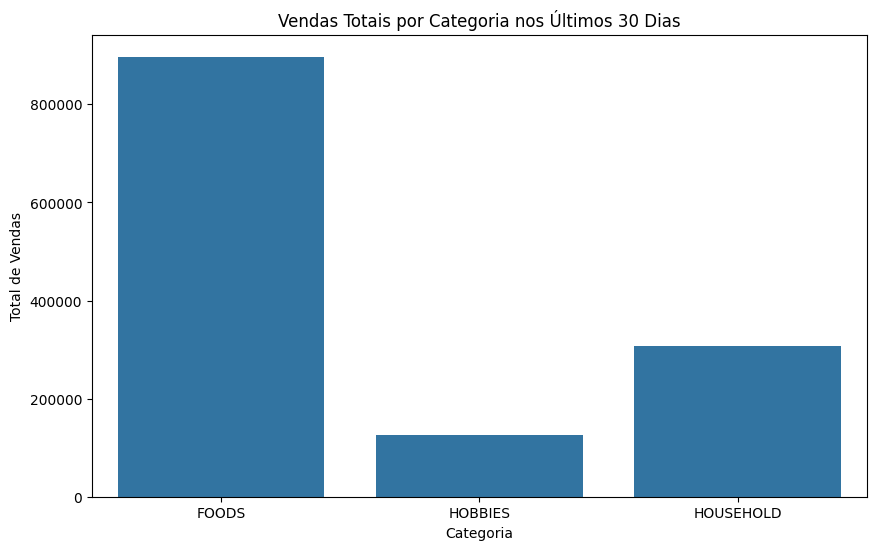

In [41]:
# Plotar o gráfico de barras com as vendas totais por categoria nos últimos 30 dias
plt.figure(figsize=(10,6))
sns.barplot(x='cat_id', y='sales', data=df_grouped)
plt.title('Vendas Totais por Categoria nos Últimos 30 Dias')
plt.xlabel('Categoria')
plt.ylabel('Total de Vendas')
plt.show()

## Modeling <a id="3"></a>


Nesta etapa, utilizo três métodos principais para previsão de vendas: **Exponential smoothing, ARIMA, e Prophet**

#### Train/Val split <a id="3.1"></a>

Os dados foram divididos em conjuntos de treino e validação para realizar os testes. O conjunto de treino abrange os últimos 400 dias até 30 dias antes do final dos dados, enquanto o conjunto de validação abrange os últimos 60 dias de vendas. O objetivo é utilizar os dados de treino para prever as vendas do conjunto de validação.


In [42]:
train_dataset = sales_train_eval[d_cols[-400:-30]]
val_dataset = sales_train_eval[d_cols[-60:]]

In [43]:
fig = make_subplots(rows=3, cols=1)

fig.add_trace(
    go.Scatter(x=np.arange(70), mode='lines', y=train_dataset.loc[0].values, marker=dict(color="dodgerblue"), showlegend=False,
               name="Original signal"),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(70, 100), y=val_dataset.loc[0].values, mode='lines', marker=dict(color="darkorange"), showlegend=False,
               name="Denoised signal"),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(70), mode='lines', y=train_dataset.loc[1].values, marker=dict(color="dodgerblue"), showlegend=False),
    row=2, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(70, 100), y=val_dataset.loc[1].values, mode='lines', marker=dict(color="darkorange"), showlegend=False),
    row=2, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(70), mode='lines', y=train_dataset.loc[2].values, marker=dict(color="dodgerblue"), showlegend=False),
    row=3, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(70, 100), y=val_dataset.loc[2].values, mode='lines', marker=dict(color="darkorange"), showlegend=False),
    row=3, col=1
)

fig.update_layout(height=1200, width=800, title_text="Train (blue) vs. Validation (orange) sales")
fig.show()

Os gráficos comparam as vendas de treino (azul) e validação (laranja) em três amostras. Observa-se que os dados de validação apresentam picos inesperados, indicando que o modelo pode não estar capturando completamente padrões sazonais ou eventos pontuais observados nos últimos 30 dias. Isso sugere a necessidade de ajustes no modelo ou de mais dados para melhorar a previsibilidade em períodos de alta variação.

### Exponential smoothing <a id="3.5"></a>

O **exponential smoothing** usa um tipo de suavização diferente, que se distingue da média móvel. As etapas de tempo anteriores são ponderadas exponencialmente e somadas para gerar a previsão. Os pesos decaem à medida que voltamos no tempo. O modelo pode ser resumido da seguinte forma:

<img src="https://i.imgur.com/IqqjOFc.png" width="520px">
<img src="https://i.imgur.com/GiyHyZf.png" width="255px">

Nas equações acima, $\alpha$ é o parâmetro de suavização. A previsão y<sub>t+1</sub> é uma média ponderada de todas as observações na série y<sub>1</sub>, … ,y<sub>t</sub>. A taxa de decaimento dos pesos é controlada pelo parâmetro α. Esse método atribui diferentes pesos a diferentes momentos no tempo, em vez de atribuir o mesmo peso a todos os períodos (como no método de média móvel). Isso garante que os dados de vendas recentes tenham mais importância do que os dados antigos ao fazer a previsão. Agora, vejamos como esse novo método de suavização se comporta em nosso conjunto de dados reduzido. Os dados de treino estão em <font color="blue">azul</font>, os dados de validação em <font color="darkorange">laranja</font> e as previsões em <font color="green">verde</font>.

In [44]:
predictions = []
for row in tqdm(train_dataset[train_dataset.columns[-60:]].values[:3]):
    fit = ExponentialSmoothing(row, seasonal_periods=3).fit()
    predictions.append(fit.forecast(60))
predictions = np.array(predictions).reshape((-1, 60))
error_exponential = np.linalg.norm(predictions[:3] - val_dataset.values[:3])/len(predictions[0])

  0%|          | 0/3 [00:00<?, ?it/s]

In [45]:
pred_1 = predictions[0]
pred_2 = predictions[1]
pred_3 = predictions[2]

fig = make_subplots(rows=3, cols=1)

fig.add_trace(
    go.Scatter(x=np.arange(70), mode='lines', y=train_dataset.loc[0].values, marker=dict(color="dodgerblue"),
               name="Train"),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(70, 100), y=val_dataset.loc[0].values, mode='lines', marker=dict(color="darkorange"),
               name="Val"),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(70, 100), y=pred_1, mode='lines', marker=dict(color="seagreen"),
               name="Pred"),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(70), mode='lines', y=train_dataset.loc[1].values, marker=dict(color="dodgerblue"), showlegend=False),
    row=2, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(70, 100), y=val_dataset.loc[1].values, mode='lines', marker=dict(color="darkorange"), showlegend=False),
    row=2, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(70, 100), y=pred_2, mode='lines', marker=dict(color="seagreen"), showlegend=False,
               name="Denoised signal"),
    row=2, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(70), mode='lines', y=train_dataset.loc[2].values, marker=dict(color="dodgerblue"), showlegend=False),
    row=3, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(70, 100), y=val_dataset.loc[2].values, mode='lines', marker=dict(color="darkorange"), showlegend=False),
    row=3, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(70, 100), y=pred_3, mode='lines', marker=dict(color="seagreen"), showlegend=False,
               name="Denoised signal"),
    row=3, col=1
)

fig.update_layout(height=1200, width=800, title_text="Exponential smoothing")
fig.show()

Podemos ver que a suavização exponencial está gerando uma linha horizontal o tempo todo. Isso acontece porque ela atribui um peso muito baixo aos períodos de tempo mais distantes, fazendo com que as previsões se estabilizem ou permaneçam constantes. No entanto, ela consegue prever a média das vendas com excelente precisão.

### ARIMA <a id="3.6"></a>

**ARIMA** significa **A**uto **R**egressivo **I**ntegrado de **M**édia **M**óvel. Enquanto os modelos de suavização exponencial se baseiam em uma descrição de tendência e sazonalidade nos dados, os modelos ARIMA visam descrever as correlações na série temporal. O vídeo abaixo explica ARIMA muito bem:

ARIAM, comportamento em nosso conjunto de dados reduzido. Os dados de treino estão em <font color="blue">azul</font>, os dados de validação em <font color="darkorange">laranja</font> e as previsões em <font color="green">verde</font>.

In [46]:
predictions = []
for row in tqdm(train_dataset[train_dataset.columns[-60:]].values[:3]):
    fit = sm.tsa.statespace.SARIMAX(row, seasonal_order=(0, 1, 1, 7)).fit()
    predictions.append(fit.forecast(60))
predictions = np.array(predictions).reshape((-1, 60))
error_arima = np.linalg.norm(predictions[:3] - val_dataset.values[:3])/len(predictions[0])

  0%|          | 0/3 [00:00<?, ?it/s]

In [47]:
pred_1 = predictions[0]
pred_2 = predictions[1]
pred_3 = predictions[2]

fig = make_subplots(rows=3, cols=1)

fig.add_trace(
    go.Scatter(x=np.arange(70), mode='lines', y=train_dataset.loc[0].values, marker=dict(color="dodgerblue"),
               name="Train"),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(70, 100), y=val_dataset.loc[0].values, mode='lines', marker=dict(color="darkorange"),
               name="Val"),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(70, 100), y=pred_1, mode='lines', marker=dict(color="seagreen"),
               name="Pred"),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(70), mode='lines', y=train_dataset.loc[1].values, marker=dict(color="dodgerblue"), showlegend=False),
    row=2, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(70, 100), y=val_dataset.loc[1].values, mode='lines', marker=dict(color="darkorange"), showlegend=False),
    row=2, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(70, 100), y=pred_2, mode='lines', marker=dict(color="seagreen"), showlegend=False,
               name="Denoised signal"),
    row=2, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(70), mode='lines', y=train_dataset.loc[2].values, marker=dict(color="dodgerblue"), showlegend=False),
    row=3, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(70, 100), y=val_dataset.loc[2].values, mode='lines', marker=dict(color="darkorange"), showlegend=False),
    row=3, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(70, 100), y=pred_3, mode='lines', marker=dict(color="seagreen"), showlegend=False,
               name="Denoised signal"),
    row=3, col=1
)

fig.update_layout(height=1200, width=800, title_text="ARIMA")
fig.show()

ARIMA é capaz de encontrar tendências de baixo e alto nível simultaneamente, ao contrário da maioria dos outros modelos que conseguem identificar apenas uma dessas. Ele consegue prever uma função periódica para cada amostra, e essas funções parecem ser bastante precisas (exceto para a segunda amostra).

### Prophet <a id="3.7"></a>

Prophet é um projeto de código aberto para previsão de séries temporais desenvolvido pelo <font color="darkblue">Facebook</font>. Ele utiliza um modelo aditivo, no qual tendências não lineares são ajustadas com sazonalidade anual, semanal e diária, além de considerar efeitos de feriados. Esse modelo funciona melhor com séries temporais que possuem fortes efeitos sazonais e várias temporadas de dados históricos. Além disso, o Prophet é mais robusto em relação a dados ausentes e mudanças de tendência quando comparado a outros modelos.

Comportamento Prophet  em nosso conjunto de dados reduzido. Os dados de treinamento estão em <font color="blue">azul</font>, os dados de validação em <font color="darkorange">laranja</font> e as previsões em <font color="green">verde</font>.

In [48]:
dates = ["2007-12-" + str(i) for i in range(1, 31)]
predictions = []
for row in tqdm(train_dataset[train_dataset.columns[-30:]].values[:3]):
    df = pd.DataFrame(np.transpose([dates, row]))
    df.columns = ["ds", "y"]
    model = Prophet(daily_seasonality=True)
    model.fit(df)
    future = model.make_future_dataframe(periods=60)
    forecast = model.predict(future)["yhat"].loc[30:].values
    predictions.append(forecast)
predictions = np.array(predictions).reshape((-1, 60))
error_prophet = np.linalg.norm(predictions[:3] - val_dataset.values[:3])/len(predictions[0])

  0%|          | 0/3 [00:00<?, ?it/s]

08:40:29 - cmdstanpy - INFO - Chain [1] start processing
08:40:29 - cmdstanpy - INFO - Chain [1] done processing
08:40:29 - cmdstanpy - INFO - Chain [1] start processing
08:40:29 - cmdstanpy - INFO - Chain [1] done processing
08:40:29 - cmdstanpy - INFO - Chain [1] start processing
08:40:30 - cmdstanpy - INFO - Chain [1] done processing


In [49]:
pred_1 = predictions[0]
pred_2 = predictions[1]
pred_3 = predictions[2]

fig = make_subplots(rows=3, cols=1)

fig.add_trace(
    go.Scatter(x=np.arange(70), mode='lines', y=train_dataset.loc[0].values, marker=dict(color="dodgerblue"),
               name="Train"),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(70, 100), y=val_dataset.loc[0].values, mode='lines', marker=dict(color="darkorange"),
               name="Val"),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(70, 100), y=pred_1, mode='lines', marker=dict(color="seagreen"),
               name="Pred"),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(70), mode='lines', y=train_dataset.loc[1].values, marker=dict(color="dodgerblue"), showlegend=False),
    row=2, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(70, 100), y=val_dataset.loc[1].values, mode='lines', marker=dict(color="darkorange"), showlegend=False),
    row=2, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(70, 100), y=pred_2, mode='lines', marker=dict(color="seagreen"), showlegend=False,
               name="Denoised signal"),
    row=2, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(70), mode='lines', y=train_dataset.loc[2].values, marker=dict(color="dodgerblue"), showlegend=False),
    row=3, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(70, 100), y=val_dataset.loc[2].values, mode='lines', marker=dict(color="darkorange"), showlegend=False),
    row=3, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(70, 100), y=pred_3, mode='lines', marker=dict(color="seagreen"), showlegend=False,
               name="Denoised signal"),
    row=3, col=1
)

fig.update_layout(height=1200, width=800, title_text="Prophet")
fig.show()

O Prophet gera previsões com formatos muito semelhantes aos do ARIMA. No entanto, ao observarmos mais de perto, percebemos uma tendência macroscópica de alta, que estava ausente no ARIMA. Nas previsões do ARIMA, o mesmo padrão se repetia exatamente. Já nas previsões do Prophet, esse padrão é deslocado verticalmente a cada oscilação. Isso indica que o Prophet consegue capturar tendências de longo prazo de forma mais eficaz do que o ARIMA.

### Model Loss/Error <a id="3.8"></a>

In [50]:
# Lista de erros e modelos
error = [error_exponential, error_arima, error_prophet]
names = ["Exponential smoothing", "ARIMA", "Prophet"]
# Criando o DataFrame
df = pd.DataFrame({'RMSE Loss': error, 'Model': names})
# Garantir que os valores de RMSE sejam numéricos
df['RMSE Loss'] = pd.to_numeric(df['RMSE Loss'])

fig = px.bar(df, y="RMSE Loss", x="Model", color="Model", title="RMSE Loss vs. Model")

# ajuste layout
fig.update_layout(yaxis=dict(range=[0, df['RMSE Loss'].max() * 1.1]))
fig.show()



In [51]:
# Previsão para validation usando Exponential Smoothing
predictions_validation = []
for row in tqdm(train_dataset[train_dataset.columns[-60:]].values):
    fit = ExponentialSmoothing(row, seasonal_periods=30).fit()
    predictions_validation.append(fit.forecast(30))

# Convertendo as previsões para um DataFrame
predictions_validation = np.array(predictions_validation).reshape((-1, 30))
predictions_validation_df = pd.DataFrame(predictions_validation, columns=[f'd{i}' for i in range(1, 31)])
predictions_validation_df = predictions_validation_df.round().astype(int)  # Arredondando para inteiros

# IDs de validação
validation_ids = sales_train_eval['id'].values  # IDs para validation

# Criando o DataFrame final para validation
predictions_validation_df.insert(0, 'id', validation_ids)  # Adiciona os IDs para validation

# Apenas id Cat FOODS
predictions_validation_df = predictions_validation_df.reset_index(drop=True)
predictions_validation_df = predictions_validation_df[predictions_validation_df['id'].str.contains('FOODS')]

# Salvando o arquivo final apenas com validation
predictions_validation_df.to_csv(f'{OUTPUTS_DIR}/foods_predict.csv', index=False)





  0%|          | 0/30490 [00:00<?, ?it/s]

## Análise do Erro de Backtesting

In [52]:
# BACKTESTING ENXUTO

# Tamanho da janela de treino e validação
window_train_size = 400
window_val_size = 30
total_size = window_train_size + window_val_size

# Selecionar uma única janela de backtesting para análise rápida
train_window = sales_train_eval[d_cols[-(total_size):-window_val_size]]
val_window = sales_train_eval[d_cols[-window_val_size:]]

# Prever os dados para a janela de validação
predictions_backtest = []
for row in tqdm(train_window.values[:10]):  # Reduzir a quantidade de amostras para acelerar
    fit = ExponentialSmoothing(row, seasonal_periods=30).fit()
    predictions_backtest.append(fit.forecast(window_val_size))

# Convertendo previsões para numpy array
predictions_backtest = np.array(predictions_backtest)

# Calculando o erro para essa janela de backtest
error_backtest = np.linalg.norm(predictions_backtest - val_window.values[:10]) / len(predictions_backtest[0])

# Exibindo o erro de backtesting
print(f'Erro de backtest na janela selecionada: {error_backtest}')



  0%|          | 0/10 [00:00<?, ?it/s]

Erro de backtest na janela selecionada: 2.3095502084875768


Durante a validação do modelo de previsão, utilizei o método de Exponential Smoothing para prever as vendas diárias dos últimos 30 dias, comparando os resultados previstos com os dados reais. O modelo apresentou um erro de 2.31.

Comparação com outros modelos:

O erro de 2.31 foi calculado utilizando o backtesting e está sendo comparado com outros modelos de previsão, como ARIMA e Prophet.
Se, por exemplo, o erro desses modelos foi maior, isso sugere que o Exponential Smoothing apresentou uma performance superior nesta aplicação específica.
Escala dos dados:

O valor de 2.31 significa que, em média, o modelo está errando por aproximadamente 2.31 unidades de vendas por dia.

<font color="Green">Conclusão:</font>.

O erro de 2.31 sugere que o modelo é relativamente preciso, especialmente em comparação com outras abordagens. Contudo, para uma avaliação completa, o erro deve ser analisado em conjunto com outras métricas e comparado com os resultados de modelos alternativos.

<font color="Darkorange">Next Step - Oportunidade de melhoria</font> .

Como estamos lidando com previsões diárias de vendas, é importante avaliar se esse erro é aceitável dado o volume de vendas diário. Por exemplo, se as vendas médias diárias forem em torno de 100 unidades, um erro de 2.31 seria considerado pequeno e o modelo estaria performando bem.


